# Tidy3D Model

Any number of [models](../models.rst) can be assigned to a [component](../_autosummary/photonforge.Component.rst) to compute its [S matrix](S_Parameters.ipynb).
In this guide, we take a look into the [Tidy3DModel](../_autosummary/photonforge.Tidy3DModel.rst), which leverages the power of Tidy3D to compute the S parameters from FDTD simulations of the 3D device.

## Component Creation

We will create the component based on the [Strip waveguide](Ports.ipynb) available in the [basic technology](../_autosummary/photonforge.basic_technology.rst).
More advanced component creation is described in the [Custom Parametric Components](Custom_Parametric_Components.ipynb) guide.

In [1]:
import numpy as np
import photonforge as pf
import tidy3d as td

pf.config.default_technology = pf.basic_technology(strip_width=0.3)

In [2]:
# Geometry parameters
port_spec = pf.config.default_technology.ports["Strip"]
length = 0.5
radius = 4
gap = 0.13
core_width, _ = port_spec.path_profile_for("WG_CORE")

coupler = pf.Component("COUPLER")

# Add left section
for layer, path in port_spec.get_paths((-0.5 * (gap + core_width) - radius, 0)):
    path.arc(-90, 0, radius, euler_fraction=0.5)
    path.segment((0, length), relative=True)
    path.arc(0, 90, radius, euler_fraction=0.5)
    coupler.add(layer, path)

# Add right section
for layer, path in port_spec.get_paths((0.5 * (gap + core_width) + radius, 0)):
    path.arc(-90, -180, radius, euler_fraction=0.5)
    path.segment((0, length), relative=True)
    path.arc(180, 90, radius, euler_fraction=0.5)
    coupler.add(layer, path)

# Add ports
coupler.add_port(coupler.detect_ports([port_spec]))

coupler

## Create the Tidy3D Model

The Tidy3D model supports many arguments related to the configurations of the FDTD simulation that will be run.
One is particularly important for most devices: setting `port_symmetries`.
Without specification, the default behavior is to execute 1 FDTD simulation per component port, so that the full S matrix can be computed.
In many cases, though, because of device symmetries, it is possible to reuse the results from one simulation in place of others.

In our example, if we simulate the field distribution using port P0 as input, we can use the same results to deduce the fields when the input is at port P2, as long as we properly account for polarization-specific phase inversions and exchange P1 and P3.
We describe this symmetry as `("P2" ,"P3", "P0", "P1")`, indicating the port replacements with respect to the **sorted** port list P0, P1, P2, P3.

In [3]:
port_symmetries = [("P2", "P3", "P0", "P1")]

model = pf.Tidy3DModel(port_symmetries=port_symmetries)

coupler.add_model(model, "Tidy3DModel")
coupler.models

{'Tidy3DModel': Tidy3DModel(run_time=None, medium=None, symmetry=(0, 0, 0), boundary_spec=None, monitors=(), structures=(), grid_spec=None, shutoff=None, subpixel=None, courant=None, port_symmetries=[('P2', 'P3', 'P0', 'P1')], bounds=((None, None, None), (None, None, None)), verbose=True)}

By setting the proper symmetries, our device can be completely characterized from 2 FDTD runs (and a few mode solver runs for phase correction) instead of 4 FDTD runs.

We can verify the number of required runs by exporting them using the function [get_simulations](../_autosummary/photonforge.Tidy3DModel.rst#photonforge.Tidy3DModel.get_simulations), which return a dictionary of Tidy3D simulations with the source names as keys (the source name is formed by the port name and mode index):

In [4]:
freqs = pf.C_0 / np.linspace(1.28, 1.36, 9)

simulations = model.get_simulations(coupler, freqs)

print(simulations.keys())

dict_keys(['P0@0', 'P1@0'])


### Testing port symmetry settings

Symmetry settings can be verified with the [test_port_symmetries](../_autosummary/photonforge.Tidy3DModel.rst#photonforge.Tidy3DModel.test_port_symmetries) method.
We override the ``grid_spec`` with a small value because we want the smallest simulations possible for testing, even if not 100% accurate.

In [5]:
assert model.test_port_symmetries(coupler, freqs, grid_spec=8)

Loading cached simulation from .tidy3d/pf_cache/N4H/fdtd_info-I3DXC6BIBBZWK5TXCYKWXDJAVEFI2YUA7TM3HOCTF34RA4CY3HGQ.json.
Loading cached simulation from .tidy3d/pf_cache/N4H/fdtd_info-KHJST6GPAFF64GAY6IOEYN633W3QIZX72V6NUE5R3CZQBP66WO5A.json.
Loading cached simulation from .tidy3d/pf_cache/N4H/fdtd_info-66KPXANGLAJLIDS7M3EW3DMIV5AQ33TXF2IQCTKUVM2QPILGDDSA.json.


Loading cached simulation from .tidy3d/pf_cache/N4H/fdtd_info-5QYHQ2WXHJRD2PHFGIHE4AW4SQZ3DOMBI7MSS2XMKBYYFMFLCY2A.json.
Progress: 100% 
Progress: 100% 


## Credit Estimation and Running

Now we are ready to compute the S parameters, but we might want to [estimate the cost](../_autosummary/photonforge.Tidy3DModel.rst#photonforge.Tidy3DModel.estimate_cost) of our simulations before that.

In [6]:
estimated_cost = model.estimate_cost(coupler, freqs)

21:00:09 -03 Maximum FlexCredit cost: 2.903 for the whole batch.

PhotonForge defaults are chosen to produce accurate simulation results in the most common cases, including poorly resonant devices.
That means that the default mesh resolution is significantly higher than the default in Tidy3D, the run time is usually overestimated, and the simulation boundary layers are conservative in trying to provide minimal reflections without risks of divergence.
Those defaults have the advantage of working "out of the box" for the great majority of planar circuits without requiring user intervention.
However, the simulation costs might be higher than what is usually found in hand-tuned Tidy3D simulations (due to finer mesh and wider absorbing layers), and the estimated cost significantly higher than the real cost of the actual run.

Of course, the `Tidy3DModel` can be created with specific settings for the component at hand to fine-tune the simulation as one would do in Tidy3D.
A more convenient approach, when possible, is to change the default [mesh refinement](../config.rst#photonforge.config.default_mesh_refinement), or the run time and boundary specification in the [default_kwargs](../config.rst#photonforge.config.default_kwargs) to appropriate values to the PDK being used and types of components being simulated.

We will keep the defaults and compute the S parameters as is:

Loading cached simulation from .tidy3d/pf_cache/N4H/fdtd_info-LDDGOVXNMDS2ZFVAETAGO2RWLYBDE4Y5MUTFPYID7E5MDIJLN6DQ.json.
Loading cached simulation from .tidy3d/pf_cache/N4H/fdtd_info-DOFUABYPMH3FHM4RPD2MNQWHBXV3R6LGROKGW2HRV3YHJ2RXXHCA.json.
Progress: 100% 


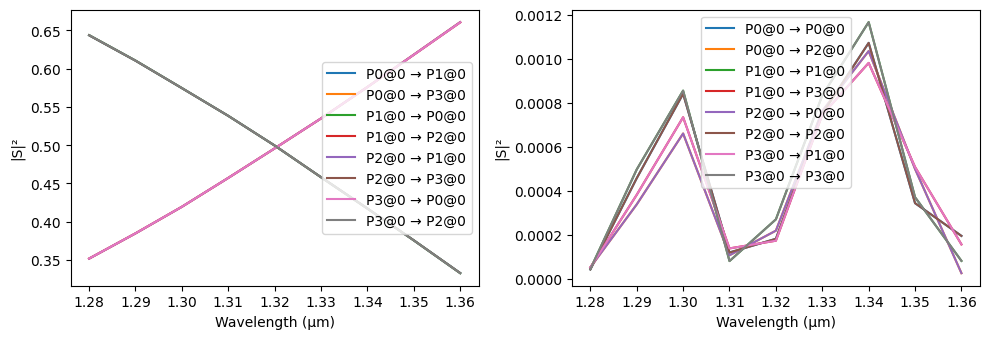

In [7]:
_ = pf.plot_s_matrix(coupler.s_matrix(freqs))

### Calculating Real Cost

After the simulations are run, we can get the associated batch data for the component.
With the task ids stored within, the real simulation cost can be computed:

In [8]:
data = model.batch_data_for(coupler)

total_cost = sum(td.web.real_cost(task_id) for task_id in data.task_ids.values())
print(f"Total FlexCredit cost: {total_cost:.3f}")

             Billed flex credit cost: 0.800.

             Note: the task cost pro-rated due to early shutoff was below the   
             minimum threshold, due to fast shutoff. Decreasing the simulation  
             'run_time' should decrease the estimated, and correspondingly the  
             billed cost of such tasks.

21:00:10 -03 Billed flex credit cost: 0.800.

             Note: the task cost pro-rated due to early shutoff was below the   
             minimum threshold, due to fast shutoff. Decreasing the simulation  
             'run_time' should decrease the estimated, and correspondingly the  
             billed cost of such tasks.

Total FlexCredit cost: 1.601


We see that the total cost is well bellow the estimated cost, which is expected, as discussed before, because our component has no resonances and the default run time specification assumes a quality factor of 5. 

## Skipping Unnecessary Runs

There are situations when we are only interested in a single or a few S matrix elements.
In such cases, it is possible to limit the number of simulation runs by selecting the ports we want to be used as sources.
As a result, only the matrix elements from those source will be computed (plus any other allowed by port symmetries).

For example, we can constrain the computation to use only the fundamental mode of port P3 as source:

In [9]:
s_limited = coupler.s_matrix(freqs, model_kwargs={"inputs": ["P3@0"]})
s_limited.elements.keys()

Loading cached simulation from .tidy3d/pf_cache/N4H/fdtd_info-MWEGDCSDRTFKVSLFMXJ7Q57U72CDKYGTCVHXJRFPSS3Q4ULBGZHA.json.
Progress: 100% 


dict_keys([('P1@0', 'P0@0'), ('P1@0', 'P3@0'), ('P1@0', 'P2@0'), ('P3@0', 'P0@0'), ('P1@0', 'P1@0'), ('P3@0', 'P1@0'), ('P3@0', 'P2@0'), ('P3@0', 'P3@0')])

## Visualizing The Fields

During early design phases, it might be necessary to visualize the field distributions on the device to guide the design.
That can be accomplished with the Tidy3D model by including a conventional Tidy3D field monitor:

In [10]:
import tidy3d as td

field_monitor = td.FieldMonitor(
    center=(0, 0, 0.11), size=(td.inf, td.inf, 0), freqs=[freqs.mean()], name="field"
)

model2 = pf.Tidy3DModel(
    monitors=[field_monitor], port_symmetries=port_symmetries, verbose=False
)

# The newly added model is set to active automatically
coupler.add_model(model2, "Tidy3DModel2")
coupler.active_model

Tidy3DModel(run_time=None, medium=None, symmetry=(0, 0, 0), boundary_spec=None, monitors=[FieldMonitor(attrs={}, type='FieldMonitor', center=(0.0, 0.0, 0.11), size=(inf, inf, 0.0), name='field', interval_space=(1, 1, 1), colocate=True, freqs=(np.float64(227202454954557.62),), apodization=ApodizationSpec(attrs={}, start=None, end=None, width=None, type='ApodizationSpec'), fields=('Ex', 'Ey', 'Ez', 'Hx', 'Hy', 'Hz'))], structures=(), grid_spec=None, shutoff=None, subpixel=None, courant=None, port_symmetries=[('P2', 'P3', 'P0', 'P1')], bounds=((None, None, None), (None, None, None)), verbose=False)

After a new computation with the new model, the batch data from the simulations will contain the field distributions from Tidy3D as usual.

In [11]:
s_matrix = coupler.s_matrix(freqs)

data = coupler.active_model.batch_data_for(coupler)
data.task_ids

Progress: 100% 


{'P0@0': 'fdve-7a3c1f48-a2dd-4899-a9d0-458589c2a480',
 'P1@0': 'fdve-bb61db8a-dba0-43da-89b0-2856243c1e44'}

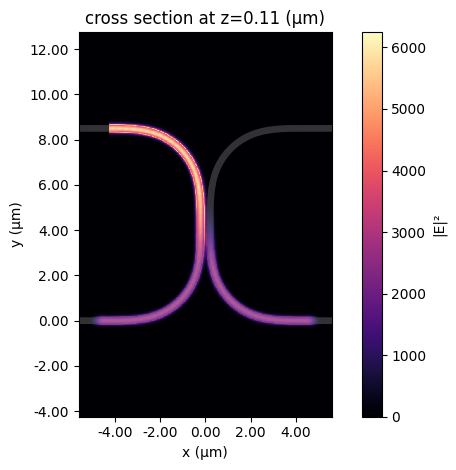

In [12]:
_ = data["P1@0"].plot_field("field", "E", val="abs^2", robust=False)

## Diving Deeper

Finally, it is also possible to get the simulations generated by the Tidy3D model to inspect and customize them at will:

In [13]:
simulations = model2.get_simulations(coupler, freqs)
simulations.keys()

dict_keys(['P0@0', 'P1@0'])

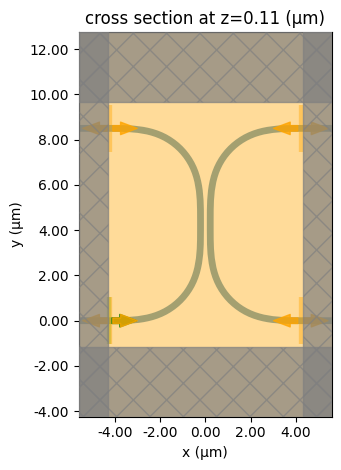

In [14]:
_ = simulations["P0@0"].plot(z=0.11)